In [1]:
import numpy as np

def divide_three_classes(img, n_classes=3):
	multiclass = np.zeros((*img.shape,n_classes), dtype=np.float32)
	
	body = np.where(img<0.4, 1., 0.)
	marker = np.where((img<0.75)&(img>=0.4), 1., 0.)
	wound = np.where(img >= 0.75, 1., 0.)

	multiclass[:,:,0] = body
	multiclass[:,:,1] = marker
	multiclass[:,:,2] = wound

	return multiclass

In [2]:
import cv2

label_3 = cv2.imread('./test_data/20250605_000003.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.

False

## preparing real datasets for training

In [1]:
import os
import random
from glob import glob

FOLDS_NUMER = 6
IMGS_X_FOLDER = 909

random.seed(346)

list_imgs = glob('../data/segmented/*.png')
random.shuffle(list_imgs)

assert len(list_imgs)//FOLDS_NUMER > IMGS_X_FOLDER


In [11]:
import pandas as pd

data = pd.DataFrame({'file' : list_imgs[:IMGS_X_FOLDER], 'folder' : [0]*IMGS_X_FOLDER})

for i in range(1,FOLDS_NUMER):
  new_rows = pd.DataFrame({'file' : list_imgs[i*IMGS_X_FOLDER:(i+1)*IMGS_X_FOLDER], 'folder' : [i]*IMGS_X_FOLDER})
  data = pd.concat([data,new_rows]).reset_index(drop=True)

data

,file,folder
0,../data/segmented/-M2Xp0A2psHObp6f7Iav.-M2XpBj...,0
1,../data/segmented/-NaQsMwhq2FAV8U5jYdh.-NaQtYF...,0
2,../data/segmented/-MN2hxShPEnW3ZwMc7YZ.-Ms4LJB...,0
3,../data/segmented/-Leujocx_cjh-Ci6MrBu.-Mkq3mZ...,0
4,../data/segmented/-MIOBNUgcr0MTphTegMf.-MIOBfY...,0
...,...,...
5449,../data/segmented/-NZz-yrFJIgMkrvvyU7k.-NZz054...,5
5450,../data/segmented/-LiwHS89iphwTuLVEkcv.-LiwHZm...,5
5451,../data/segmented/-MX_tivv7eIFmiM5It8l.-MX_trj...,5
5452,../data/segmented/-NKqt26V9R-mBxkxU81X.-NKrFM2...,5


In [20]:
import os
import cv2

import numpy as np
from tqdm.auto import tqdm



for i in range(FOLDS_NUMER):
  saving_folder = f'./train_data_real{i}/'
  os.makedirs(saving_folder, exist_ok=True)
  saving_wound = saving_folder + 'wound/'
  saving_sem_mask = saving_folder + 'semantic_masks/'
  os.makedirs(saving_wound, exist_ok=True)
  os.makedirs(saving_sem_mask, exist_ok=True)
  
  data_folder = '../data/segmented/'
  wound_mask = '../data/masks/'
  body_mask = '../data/body_mask/'
  marker_mask = '../data/marker_mask/'

  rows = (data['folder']==i)

  for file in tqdm(data[rows]['file']):
    f = file.split('/')[-1]
    img = cv2.imread(data_folder+f)
    wound = cv2.imread(wound_mask+f, cv2.IMREAD_GRAYSCALE)
    body = cv2.imread(body_mask+f, cv2.IMREAD_GRAYSCALE)
    if os.path.exists(marker_mask+f):
      marker = cv2.imread(marker_mask+f, cv2.IMREAD_GRAYSCALE)
    else:
      marker = None

    semantic = np.zeros_like(wound).astype(np.float32)
    semantic = np.where(body!=0, np.ones_like(wound)*(1/3), semantic)
    semantic = np.where(wound!=0, np.ones_like(wound), semantic)
    if marker is not None:
      semantic = np.where(marker!=0, np.ones_like(wound)*(2/3), semantic)

    semantic = (semantic*255).astype(np.uint8)

    cv2.imwrite(saving_sem_mask+f, semantic)
    cv2.imwrite(saving_wound+f, img)








  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

# Analyse losses

In [7]:
import pandas as pd
import os
from glob import glob

losses_paths = [n + '/lossi.csv' for n in glob('saved_models/u2net_*')]
models_names = [n.split('/')[1].split('_')[-1] for n in losses_paths]



In [15]:
pd.read_csv(losses_paths[0])['0'].values

dict_loss = {}

for name, path in zip(models_names, losses_paths):
  lossi = pd.read_csv(path)['0'].values[::100]
  dict_loss[name] = lossi

lossis = pd.DataFrame(dict_loss)


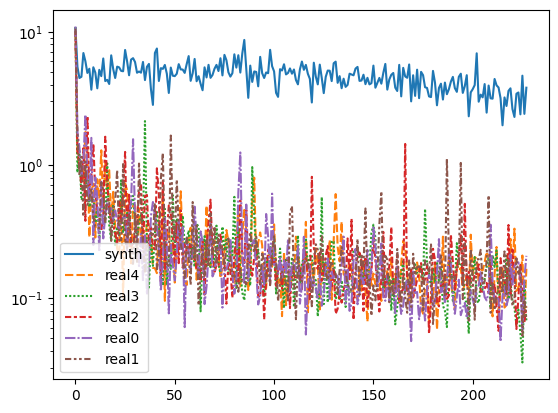

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=lossis)
plt.yscale('log')

# Testing the synthetic model

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from data_loader import RescaleT
from data_loader import RandomCrop
from data_loader import ToTensorLab
from data_loader import SemanticSalObjDataset

from glob import glob

salobj_dataset = SemanticSalObjDataset(
  img_name_list=glob('train_data_real/train_data_real0/wound/*.png'),
  lbl_name_list=glob('train_data_real/train_data_real0/semantic_mask/*.png'),
  transform=transforms.Compose([
    RescaleT(320),
    RandomCrop(288),
    ToTensorLab(flag=0)]))

dataloader = DataLoader(salobj_dataset, batch_size=1)


In [4]:
import torch
from model import SU2NET

model = SU2NET()

model.load_state_dict(torch.load('saved_models/u2net_synth/u2net_bce_itr_10_train_5.223644_tar_0.740114.pth', map_location='cpu'))
model.eval()

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

/Users/tommygiak/Documents/wounds/U-2-Net/model/SemU2Net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


(-1.6150018, 1.5719571)

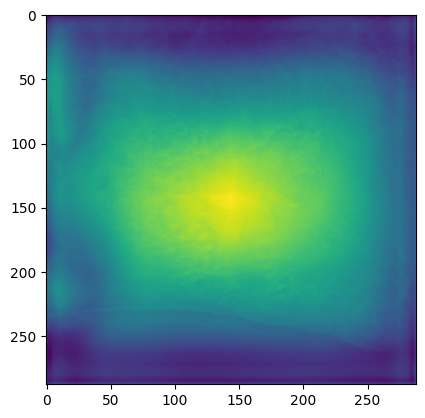

In [6]:
import matplotlib.pyplot as plt

with torch.no_grad():

  data = next(iter(dataloader))
  img = data['image'].type(torch.float32)
  gt = data['label'].type(torch.float32)


  out, *_ = model(img)
  out = out.squeeze()[-1].numpy()

plt.imshow(out)
out.min(), out.max()


In [36]:
img

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 0.9118,  0.9870,  0.9091,  ...,  0.5005,  0.8238,  1.2119],
          [ 0.9615,  0.9542,  0.8983,  ...,  0.5176,  0.6670,  1.3489],
          [ 0.8777,  0.9034,  0.8894,  ...,  0.4047,  0.8061,  1.3609]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.9853,  1.1341,  1.0370,  ...,  0.6055,  0.9890,  1.3201],
          [ 1.0573,  1.1316,  1.0743,  ...,  0.5907,  0.7905,  1.4350],
          [ 1.0033,  1.1108,  1.1057,  ...,  0.3997,  0.8477,  1.3810]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

## Testing the training for synthetic images

In [ ]:
import os
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision.transforms as standard_transforms

import pandas as pd
import numpy as np
import glob
import os

from data_loader import Rescale
from data_loader import RescaleT
from data_loader import RandomCrop
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SemanticSalObjDataset

from model import SU2NET
from model import SU2NETP


model_name = 'u2net'
label_ext = '.png'
batch_size_train = 8


### Training with synthetic images

print('TRAINING WITH SYNTH IMAGES!')

tra_img_name_list = glob.glob('train_data_synthetic/validated_fruci/' + '*.png')

tra_lbl_name_list = []
for img_path in tra_img_name_list:
  img_name = img_path.split('/')[-1]

  aaa = img_name.split(".")
  bbb = aaa[0:-1]
  imidx = bbb[0]
  for k in range(1,len(bbb)):
      imidx = imidx + "." + bbb[k]

  tra_lbl_name_list.append('train_data_synthetic/semantic_masks/' + label_ext)

print("---")
print("train images: ", len(tra_img_name_list))
print("train labels: ", len(tra_lbl_name_list))
print("---")

train_num = len(tra_img_name_list)

salobj_dataset = SemanticSalObjDataset(
  img_name_list=tra_img_name_list,
  lbl_name_list=tra_lbl_name_list,
  transform=transforms.Compose([
    RescaleT(320),
    RandomCrop(288),
    ToTensorLab(flag=0)]))

salobj_dataloader = DataLoader(salobj_dataset, batch_size=batch_size_train, shuffle=True)#, num_workers=1)


# ------- 3. define model --------
# define the net
if(model_name=='u2net'):
  net = SU2NET(in_ch=3, out_ch=4)
elif(model_name=='u2netp'):
  net = SU2NETP(in_ch=3, out_ch=4)

if torch.cuda.is_available():
  net.cuda()

# ------- 4. define optimizer --------
print("---define optimizer...")
optimizer = optim.Adam(net.parameters(), lr=0.0004, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=1, end_factor=1/10, total_iters=50)

# ------- 5. training process --------
print("---start training...")
ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0
save_frq = 10 # save the model every 2000 iterations
lossi = []

for epoch in range(0, epoch_num):
  net.train()

  for k, data in enumerate(salobj_dataloader):
    ite_num = ite_num + 1
    ite_num4val = ite_num4val + 1

    inputs, labels = data['image'], data['label']

    inputs = inputs.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)

    # wrap them in Variable
    if torch.cuda.is_available():
      inputs_v, labels_v = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(),
                                                                                  requires_grad=False)
    else:
      inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

    # y zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    d0, d1, d2, d3, d4, d5, d6 = net(inputs_v)
    loss2, loss = muti_ce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v)

    loss.backward()
    optimizer.step()
    scheduler.step()

    # # print statistics
    running_loss += loss.data.item()
    running_tar_loss += loss2.data.item()
    lossi.append(loss.item())

    # del temporary outputs and loss
    del d0, d1, d2, d3, d4, d5, d6, loss2, loss


    print("[train synthetic, epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
    epoch + 1, epoch_num, (k + 1) * batch_size_train, train_num, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))
  
  os.makedirs('saved_models/u2net_synth/',exist_ok=True)
  if (epoch+1) % save_frq == 0:
    torch.save(net.state_dict(), 'saved_models/u2net_synth/' + model_name + "_bce_itr_%d_train_%3f_tar_%3f.pth" % (epoch+1, running_loss / ite_num4val, running_tar_loss / ite_num4val))
    running_loss = 0.0
    running_tar_loss = 0.0
    net.train()  # resume train
    ite_num4val = 0

pd.DataFrame(lossi).to_csv('saved_models/u2net_synth/'+'lossi.csv')